In [1]:
# Dcard intern hw
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# processor setting
print(torch.__version__)
print(torch.version.cuda)
if torch.cuda.is_available():
    cuda0 = torch.device(0)
    print(torch.cuda.get_device_name(cuda0))

1.12.1+cu113
11.3
NVIDIA GeForce RTX 2070


In [3]:
# load data
trainDataset = pd.read_csv("intern_homework_train_dataset.csv").reset_index(drop=True)
validDataset = pd.read_csv("intern_homework_public_test_dataset.csv").reset_index(drop=True)
trainDataset.to_html("TrainData.html")
validDataset.to_html("ValidData.html")
print("train dataset size:", trainDataset.shape)
print("valid dataset size:", validDataset.shape)

train dataset size: (50000, 18)
valid dataset size: (10000, 18)


In [4]:
# Data analyze
print("Checking null value")
print("Train dataset:")
print(trainDataset.isnull().any())
print("Valid dataset:")
print(validDataset.isnull().any())
print("Checking data type")
print(trainDataset.dtypes)

Checking null value
Train dataset:
title               False
created_at          False
like_count_1h       False
like_count_2h       False
like_count_3h       False
like_count_4h       False
like_count_5h       False
like_count_6h       False
comment_count_1h    False
comment_count_2h    False
comment_count_3h    False
comment_count_4h    False
comment_count_5h    False
comment_count_6h    False
forum_id            False
author_id           False
forum_stats         False
like_count_24h      False
dtype: bool
Valid dataset:
title               False
created_at          False
like_count_1h       False
like_count_2h       False
like_count_3h       False
like_count_4h       False
like_count_5h       False
like_count_6h       False
comment_count_1h    False
comment_count_2h    False
comment_count_3h    False
comment_count_4h    False
comment_count_5h    False
comment_count_6h    False
forum_id            False
author_id           False
forum_stats         False
like_count_24h      False
dt

In [5]:
# Word embedding with train dataset
from transformers import BertTokenizer, BertModel
import gc

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese').cuda(device=cuda0)

title_list = list(trainDataset["title"])
embeddings_list = []
batch_size = 64

for i in range(0, len(title_list), batch_size):
    titles = title_list[i:i+batch_size]

    # tokenize titles
    inputs = tokenizer(titles, padding=True, truncation=True, max_length=50, return_tensors='pt').to(cuda0)

    # get embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # get embeddings from last hidden layer
    last_hidden_states = outputs.last_hidden_state
    embeddings = torch.mean(last_hidden_states, dim=1)  # average pooling

    embeddings_list.append(embeddings)

    del inputs, outputs, last_hidden_states, embeddings
    torch.cuda.empty_cache()

    print(f"Processed {i+batch_size}/{len(title_list)} titles.")

train_embeddings = torch.cat(embeddings_list, dim=0)

# check shape
print(train_embeddings.shape)

gc.collect()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processed 64/50000 titles.
Processed 128/50000 titles.
Processed 192/50000 titles.
Processed 256/50000 titles.
Processed 320/50000 titles.
Processed 384/50000 titles.
Processed 448/50000 titles.
Processed 512/50000 titles.
Processed 576/50000 titles.
Processed 640/50000 titles.
Processed 704/50000 titles.
Processed 768/50000 titles.
Processed 832/50000 titles.
Processed 896/50000 titles.
Processed 960/50000 titles.
Processed 1024/50000 titles.
Processed 1088/50000 titles.
Processed 1152/50000 titles.
Processed 1216/50000 titles.
Processed 1280/50000 titles.
Processed 1344/50000 titles.
Processed 1408/50000 titles.
Processed 1472/50000 titles.
Processed 1536/50000 titles.
Processed 1600/50000 titles.
Processed 1664/50000 titles.
Processed 1728/50000 titles.
Processed 1792/50000 titles.
Processed 1856/50000 titles.
Processed 1920/50000 titles.
Processed 1984/50000 titles.
Processed 2048/50000 titles.
Processed 2112/50000 titles.
Processed 2176/50000 titles.
Processed 2240/50000 titles.
P

4

In [6]:
# word embedding with valid dataset

title_list = list(validDataset["title"])
batch_size = 64
embeddings_list = []

for i in range(0, len(title_list), batch_size):
    titles = title_list[i:i+batch_size]
    
    inputs = tokenizer(titles, padding=True, truncation=True, max_length=50, return_tensors='pt').to(cuda0)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    last_hidden_states = outputs.last_hidden_state
    embeddings = torch.mean(last_hidden_states, dim=1)
    
    embeddings_list.append(embeddings)
    
    del titles, inputs, outputs, last_hidden_states
    torch.cuda.empty_cache()
    
    print(f"Processed {i+batch_size}/{len(title_list)} titles.")
    
valid_embeddings = torch.cat(embeddings_list, dim=0)

print(valid_embeddings.shape)

gc.collect()

Processed 64/10000 titles.
Processed 128/10000 titles.
Processed 192/10000 titles.
Processed 256/10000 titles.
Processed 320/10000 titles.
Processed 384/10000 titles.
Processed 448/10000 titles.
Processed 512/10000 titles.
Processed 576/10000 titles.
Processed 640/10000 titles.
Processed 704/10000 titles.
Processed 768/10000 titles.
Processed 832/10000 titles.
Processed 896/10000 titles.
Processed 960/10000 titles.
Processed 1024/10000 titles.
Processed 1088/10000 titles.
Processed 1152/10000 titles.
Processed 1216/10000 titles.
Processed 1280/10000 titles.
Processed 1344/10000 titles.
Processed 1408/10000 titles.
Processed 1472/10000 titles.
Processed 1536/10000 titles.
Processed 1600/10000 titles.
Processed 1664/10000 titles.
Processed 1728/10000 titles.
Processed 1792/10000 titles.
Processed 1856/10000 titles.
Processed 1920/10000 titles.
Processed 1984/10000 titles.
Processed 2048/10000 titles.
Processed 2112/10000 titles.
Processed 2176/10000 titles.
Processed 2240/10000 titles.
P

0

In [7]:
# data splitting and concatenating

# from sklearn.decomposition import PCA
# pca = PCA(n_components=16)
# train_embeddings = torch.tensor(pca.fit_transform(train_embeddings.cpu()), dtype=torch.float32).to(cuda0)
# valid_embeddings = torch.tensor(pca.fit_transform(valid_embeddings.cpu()), dtype=torch.float32).to(cuda0)

y_train = torch.tensor(np.array(trainDataset.iloc[:, -1]), device=cuda0, dtype=torch.float32).reshape(50000, 1)
y_valid = torch.tensor(np.array(validDataset.iloc[:, -1]), device=cuda0, dtype=torch.float32).reshape(10000, 1)
print("y_train:", y_train.shape, y_train.type())
print("y_valid:", y_valid.shape, y_valid.type())

trainFeatures = torch.tensor(np.array(trainDataset.drop(["title", "created_at", "forum_id", "author_id", "forum_stats", "like_count_24h"], axis=1)), device=cuda0, dtype=torch.float32)
validFeatures = torch.tensor(np.array(validDataset.drop(["title", "created_at", "forum_id", "author_id", "forum_stats", "like_count_24h"], axis=1)), device=cuda0, dtype=torch.float32)

x_train = torch.cat((train_embeddings, trainFeatures), dim=1).to(device=cuda0)
x_valid = torch.cat((valid_embeddings, validFeatures), dim=1).to(device=cuda0)
print("x_train:", x_train.size(), x_train.type())
print("x_valid:", x_valid.size(), x_valid.type())

del trainFeatures, validFeatures
gc.collect()

y_train: torch.Size([50000, 1]) torch.cuda.FloatTensor
y_valid: torch.Size([10000, 1]) torch.cuda.FloatTensor
x_train: torch.Size([50000, 780]) torch.cuda.FloatTensor
x_valid: torch.Size([10000, 780]) torch.cuda.FloatTensor


0

In [98]:
# Word embedding network define
class bertNetwork(nn.Module):
    def __init__(self):
        super(bertNetwork, self).__init__()
        self.inputLayer = nn.Linear(768, 512).to(device=cuda0) # 768 word embedding
        self.hidden1 = nn.Linear(512, 256).to(device=cuda0)
        self.outputLayer = nn.Linear(256, 64).to(device=cuda0)
        self.relu = nn.ReLU().to(device=cuda0)
        self.dropout = nn.Dropout(p=0.5).to(device=cuda0)
        self.bn1 = nn.BatchNorm1d(512).to(device=cuda0)
        self.bn2 = nn.BatchNorm1d(256).to(device=cuda0)
        
    def forward(self, x):
        x = self.inputLayer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.outputLayer(x)
        return x

In [99]:
# Other feature network define
class featureNetwork(nn.Module):
    def __init__(self):
        super(featureNetwork, self).__init__()
        self.inputLayer = nn.Linear(12, 32).to(device=cuda0) # 12 other features(like 1~6hr + comment 1~6hr)
        self.outputLayer = nn.Linear(32, 64).to(device=cuda0)
        self.relu = nn.ReLU().to(device=cuda0).to(device=cuda0)
        self.bn = nn.BatchNorm1d(512).to(device=cuda0)
        
    def forward(self, x):
        x = self.inputLayer(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.outputLayer(x)
        return x

In [100]:
# Merge network define
class mergeNetwork(nn.Module):
    def __init__(self):
        super(mergeNetwork, self).__init__()
        self.bert_net = bertNetwork().to(device=cuda0)
        self.feature_net = featureNetwork().to(device=cuda0)
        self.inputLayer = nn.Linear(128, 64).to(device=cuda0) # 128 word embedding network + 128 feature network
        self.hidden1 = nn.Linear(64, 32).to(device=cuda0)
        self.hidden2 = nn.Linear(32, 16).to(device=cuda0)
        self.outputLayer = nn.Linear(16, 1).to(device=cuda0)
        self.relu = nn.ReLU().to(device=cuda0)
        self.dropout = nn.Dropout(p=0.5).to(device=cuda0)
        self.bn1 = nn.BatchNorm1d(64).to(device=cuda0)
        self.bn2 = nn.BatchNorm1d(32).to(device=cuda0)
        self.bn3 = nn.BatchNorm1d(16).to(device=cuda0)
        
    def forward(self, embedding, feature):
        embedding_out = self.bert_net(embedding)
        feature_out = self.feature_net(feature)
        x = torch.cat((embedding_out, feature_out), dim=1).to(device=cuda0)
        x = self.inputLayer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.outputLayer(x)
        return x

In [101]:
# # Neural network define
# class network(nn.Module):
#     def __init__(self):
#         super(network, self).__init__()
#         self.inputLayer = nn.Linear(780, 256).to(device=cuda0) # 768 word embedding + 12 feature(like 1~6hr + comment 1~6hr)
#         self.hidden1 = nn.Linear(256, 128).to(device=cuda0)
#         self.hidden2 = nn.Linear(128, 64).to(device=cuda0)
#         self.outputLayer = nn.Linear(64, 1).to(device=cuda0)
#         self.relu = nn.ReLU().to(device=cuda0)
#         self.dropout = nn.Dropout(p=0.5).to(device=cuda0)
        
#     def forward(self, x):
#         x = self.inputLayer(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.hidden1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.hidden2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.outputLayer(x)
#         return x

In [102]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.decomposition import PCA

# pca = PCA(n_components=32)
# train_embeddings = torch.tensor(pca.fit_transform(train_embeddings.cpu()))
# valid_embeddings = torch.tensor(pca.fit_transform(valid_embeddings.cpu()))

# train_x = torch.cat((train_embeddings, trainFeatures.cpu()), dim=1)
# valid_x = torch.cat((valid_embeddings, validFeatures.cpu()), dim=1)

# # train_x = x_train
# train_y = y_train.reshape(50000,).cpu()
# # valid_x = x_valid
# vaiid_y = y_valid.reshape(10000,).cpu()

# # 定義隨機森林模型
# rf = RandomForestRegressor(n_estimators=100, random_state=42)

# # 訓練模型
# rf.fit(train_x, train_y)

# # 預測測試集標籤
# y_pred = rf.predict(valid_x)

# # 計算MAPE
# mape = mean_absolute_percentage_error(vaiid_y, y_pred)

# print(f"MAPE: {mape:.2f}")

In [103]:
from torchmetrics import MeanAbsolutePercentageError

minMape = float('inf')

model = mergeNetwork().to(cuda0)
mseLoss = nn.MSELoss().to(cuda0)
l1loss = nn.SmoothL1Loss().to(cuda0)
mape = MeanAbsolutePercentageError().to(cuda0)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [111]:
# hyperparameters
epochs = 600
learning_rate = 1e-3
weight_decay = 1e-3
batch_size = 256

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)
# model.load_state_dict(torch.load('model_save/model_epoch_0704_0.17.pt'))

In [114]:
train_losses = []
val_losses = []
train_mapes = []
val_mapes = []

for epoch in range(epochs):
    for (x_batch, y_batch), (x_val_batch, y_val_batch) in zip(train_loader, val_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch[:, :768], x_batch[:, 768:])
        loss = l1loss(y_batch, y_pred)
        train_mape = mape(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        y_val_pred = model(x_val_batch[:, :768], x_val_batch[:, 768:])
        val_mape = mape(y_val_pred, y_val_batch)
        
    # print loss and mape
    if((epoch+1) % 10 == 0):
        print ('Epoch [{}/{}], Loss: {:.4f}, train_mape: {:2.2f}%, val_mape: {:2.2f}%'
           .format(epoch+1, epochs, loss.item(), train_mape*100, val_mape*100))
    # save better model
    if(val_mape < minMape):
        torch.save(model.state_dict(), 'model_save/model_epoch_{:04d}_{:.2f}.pt'.format(epoch, val_mape))
        minMape = val_mape
    
    # learning rate adjust
    scheduler.step()
    if((epoch+1) % 300 == 0):
        print("Learning rate:", scheduler.get_lr())
    
    train_losses.append(loss.item())
    val_losses.append(l1loss(y_val_pred, y_val_batch).item())
    train_mapes.append(train_mape)
    val_mapes.append(val_mape)

    del x_batch, y_batch, x_val_batch, y_val_batch
    del y_pred, loss, train_mape, y_val_pred, val_mape
    torch.cuda.empty_cache()

gc.collect()

Epoch [10/600], Loss: 17.3187, train_mape: 38.03%, val_mape: 38.26%
Epoch [20/600], Loss: 14.8536, train_mape: 39.91%, val_mape: 42.56%
Epoch [30/600], Loss: 15.4225, train_mape: 40.54%, val_mape: 33.78%
Epoch [40/600], Loss: 33.7768, train_mape: 37.16%, val_mape: 35.50%
Epoch [50/600], Loss: 12.4961, train_mape: 35.18%, val_mape: 40.25%
Epoch [60/600], Loss: 33.5348, train_mape: 39.71%, val_mape: 34.04%
Epoch [70/600], Loss: 23.0930, train_mape: 39.62%, val_mape: 27.36%
Epoch [80/600], Loss: 19.9213, train_mape: 41.20%, val_mape: 43.72%
Epoch [90/600], Loss: 11.6907, train_mape: 39.43%, val_mape: 50.88%
Epoch [100/600], Loss: 17.7068, train_mape: 39.16%, val_mape: 34.22%
Epoch [110/600], Loss: 12.0438, train_mape: 37.48%, val_mape: 42.26%
Epoch [120/600], Loss: 29.1642, train_mape: 40.79%, val_mape: 25.00%
Epoch [130/600], Loss: 14.8116, train_mape: 38.90%, val_mape: 31.96%
Epoch [140/600], Loss: 17.6174, train_mape: 37.79%, val_mape: 28.89%
Epoch [150/600], Loss: 19.6509, train_mape:

9

Train: tensor(0.3937, device='cuda:0', grad_fn=<SqueezeBackward0>)
Valid: tensor(0.3961, device='cuda:0', grad_fn=<SqueezeBackward0>)


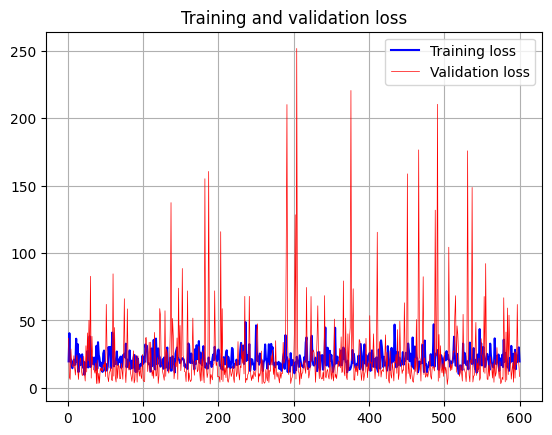

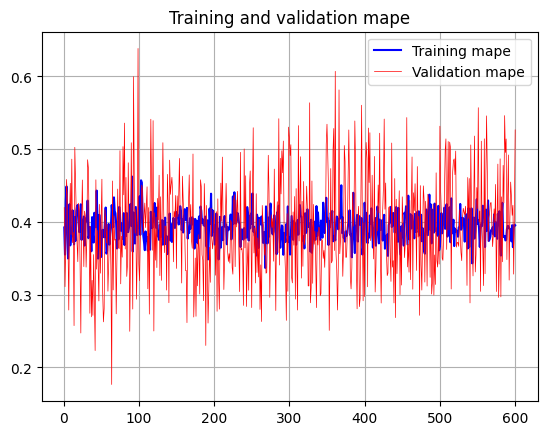

In [115]:
# model.load_state_dict(torch.load('model_save/model_epoch_0704_0.17.pt'))
print("Train:", mape(model(x_train[:, :768], x_train[:, 768:]), y_train))
print("Valid:", mape(model(x_valid[:, :768], x_valid[:, 768:]), y_valid))

epoch = range(1, epochs + 1)
plt.plot(epoch, train_losses,'b', label='Training loss')
plt.plot(epoch, val_losses,'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(epoch, train_mapes,'b', label='Training mape')
plt.plot(epoch, val_mapes,'r', label='Validation mape', linewidth=0.5)
plt.title('Training and validation mape')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [31]:
testDataset = pd.read_csv("intern_homework_private_test_dataset.csv").reset_index(drop=True)
print(testDataset.shape)
print(testDataset.isnull().any())

(10000, 17)
title               False
created_at          False
like_count_1h       False
like_count_2h       False
like_count_3h       False
like_count_4h       False
like_count_5h       False
like_count_6h       False
comment_count_1h    False
comment_count_2h    False
comment_count_3h    False
comment_count_4h    False
comment_count_5h    False
comment_count_6h    False
forum_id            False
author_id           False
forum_stats         False
dtype: bool


In [32]:
# Word embedding with test dataset
from transformers import BertTokenizer, BertModel
import gc

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
bertModel = BertModel.from_pretrained('bert-base-chinese').cuda(device=cuda0)

title_list = list(testDataset["title"])
batch_size = 32
embeddings_list = []

for i in range(0, len(title_list), batch_size):
    titles = title_list[i:i+batch_size]

    inputs = tokenizer(titles, padding=True, truncation=True, max_length=50, return_tensors='pt').to(cuda0)

    with torch.no_grad():
        outputs = bertModel(**inputs)
        
    last_hidden_states = outputs.last_hidden_state
    embeddings = torch.mean(last_hidden_states, dim=1)

    embeddings_list.append(embeddings)

    del inputs, outputs, last_hidden_states, embeddings
    torch.cuda.empty_cache()

    print(f"Processed {i+batch_size}/{len(title_list)} titles.")

test_embeddings = torch.cat(embeddings_list, dim=0)

print(test_embeddings.shape)

gc.collect()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processed 32/10000 titles.
Processed 64/10000 titles.
Processed 96/10000 titles.
Processed 128/10000 titles.
Processed 160/10000 titles.
Processed 192/10000 titles.
Processed 224/10000 titles.
Processed 256/10000 titles.
Processed 288/10000 titles.
Processed 320/10000 titles.
Processed 352/10000 titles.
Processed 384/10000 titles.
Processed 416/10000 titles.
Processed 448/10000 titles.
Processed 480/10000 titles.
Processed 512/10000 titles.
Processed 544/10000 titles.
Processed 576/10000 titles.
Processed 608/10000 titles.
Processed 640/10000 titles.
Processed 672/10000 titles.
Processed 704/10000 titles.
Processed 736/10000 titles.
Processed 768/10000 titles.
Processed 800/10000 titles.
Processed 832/10000 titles.
Processed 864/10000 titles.
Processed 896/10000 titles.
Processed 928/10000 titles.
Processed 960/10000 titles.
Processed 992/10000 titles.
Processed 1024/10000 titles.
Processed 1056/10000 titles.
Processed 1088/10000 titles.
Processed 1120/10000 titles.
Processed 1152/1000

3870

In [33]:
testFeatures = torch.tensor(np.array(testDataset.drop(["title", "created_at", "forum_id", "author_id", "forum_stats"], axis=1)), device=cuda0, dtype=torch.float32)
x_test = torch.cat((test_embeddings, testFeatures), dim=1).to(cuda0)
print("x_test: ", x_test.size(), x_test.type())

x_test:  torch.Size([10000, 780]) torch.cuda.FloatTensor


In [36]:
predict = torch.tensor(model(x_test[:, :768], x_test[:, 768:]), dtype=int).cpu().numpy()
resultPath = 'result.csv'
pd.DataFrame(predict).to_csv(resultPath, header = ["like_count_24h"], index = None)

C:\Users\user\AppData\Local\Temp\ipykernel_14132\1158811409.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict = torch.tensor(model(x_test[:, :768], x_test[:, 768:]), dtype=int).cpu().numpy()
